In [1]:
import numpy as np
import matplotlib.pylab as plt
from math import *
#from sklearn.models import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn import svm
import pandas as pd
import seaborn as sns
from pylab import rcParams
from matplotlib import rc
from mpl_toolkits.mplot3d import Axes3D
import time
%matplotlib notebook

In [2]:
import torch
import gc
import torch.nn as nn
from tqdm import tqdm_notebook as tqdm
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
RANDOM_SEED = 42
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ['#01BEFE', '#FFDD00', '#FF7D00', '#FF006D', '#ADFF02', '#8F00FF']
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8


In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
from sklearn.metrics import mean_squared_error as mse

In [6]:
df = pd.read_csv('inputs/DS1_1440.csv')

In [7]:
class WindDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        item = self.x[idx]
        label = self.y[idx]
        
        return item, label

In [8]:
class LSTMForecast(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMForecast, self).__init__()
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        # self.seq_length = seq_length #sequence length
        self.num_classes = num_classes #number of classes

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 100) #fully connected 1
        self.fc = nn.Linear(100, num_classes) #fully connected last layer

        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
        return out

In [9]:
from processing import create_features, split_data

In [10]:
window_size = 5
train_len = int(.6*df.shape[0])

In [11]:
train_data, val_data, test_data = split_data(df.wind_speed.values, train_len)
train_data = np.float32(train_data)
val_data = np.float32(val_data)
test_data = np.float32(test_data)

In [12]:
train_data.shape

(864,)

In [13]:
xtrain, ytrain = create_features(train_data, window_size)
xval, yval = create_features(val_data, window_size)
xtest, ytest = create_features(test_data, window_size)

In [14]:
train = WindDataset(xtrain.reshape(xtrain.shape[0], 1, xtrain.shape[1]), ytrain)
valid = WindDataset(xval.reshape(xval.shape[0], 1, xval.shape[1]), yval)
test = WindDataset(xtest.reshape(xtest.shape[0], 1, xtest.shape[1]), ytest)
train_loader = torch.utils.data.DataLoader(train, batch_size=1, shuffle=False)
valid_loader = torch.utils.data.DataLoader(train, batch_size=1, shuffle=False)
test_loader = torch.utils.data.DataLoader(test, batch_size=1, shuffle=False)

In [15]:

input_size = 5 #number of features
hidden_size = 200 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 
seq_length = 1

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = LSTMForecast(input_size, hidden_size, num_layers, num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = nn.MSELoss()

In [17]:
for p in model.parameters():
    print(p.shape)

torch.Size([800, 5])
torch.Size([800, 200])
torch.Size([800])
torch.Size([800])
torch.Size([100, 200])
torch.Size([100])
torch.Size([1, 100])
torch.Size([1])


In [18]:
NUM_EPOCHS = 200

In [19]:
train_losses = []
valid_losses = []
def Train():
    
    running_loss = .0
    
    model.train()
    
    for idx, (inputs,labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        preds = model(inputs)
        loss = criterion(preds,labels)
        loss.backward()
        optimizer.step()
        running_loss += loss
        
    train_loss = running_loss/len(train_loader)
    train_losses.append(train_loss.detach().numpy())
    
    print(f'train_loss {train_loss}')
    
def Valid():
    running_loss = .0
    
    model.eval()
    
    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(valid_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            preds = model(inputs)
            loss = criterion(preds,labels)
            running_loss += loss
            
        valid_loss = running_loss/len(valid_loader)
        valid_losses.append(valid_loss.detach().numpy())
        print(f'valid_loss {valid_loss}')

In [20]:
for epoch in range(NUM_EPOCHS):
    print('epochs {}/{}'.format(epoch+1, NUM_EPOCHS))
    Train()
    Valid()
    gc.collect()

epochs 1/200
train_loss 83.17433166503906
valid_loss 78.18549346923828
epochs 2/200
train_loss 67.96253204345703
valid_loss 54.95186233520508
epochs 3/200
train_loss 39.839752197265625
valid_loss 25.46060562133789
epochs 4/200
train_loss 15.250975608825684
valid_loss 7.4896240234375
epochs 5/200
train_loss 4.095654487609863
valid_loss 2.1113216876983643
epochs 6/200
train_loss 1.6697098016738892
valid_loss 1.4712435007095337
epochs 7/200
train_loss 1.45561945438385
valid_loss 1.4259226322174072
epochs 8/200
train_loss 1.4262064695358276
valid_loss 1.3961613178253174
epochs 9/200
train_loss 1.3954929113388062
valid_loss 1.3638062477111816
epochs 10/200
train_loss 1.3629159927368164
valid_loss 1.3311235904693604
epochs 11/200
train_loss 1.329946517944336
valid_loss 1.298755168914795
epochs 12/200
train_loss 1.2972270250320435
valid_loss 1.2665181159973145
epochs 13/200
train_loss 1.2651137113571167
valid_loss 1.2350702285766602
epochs 14/200
train_loss 1.2338653802871704
valid_loss 1.204

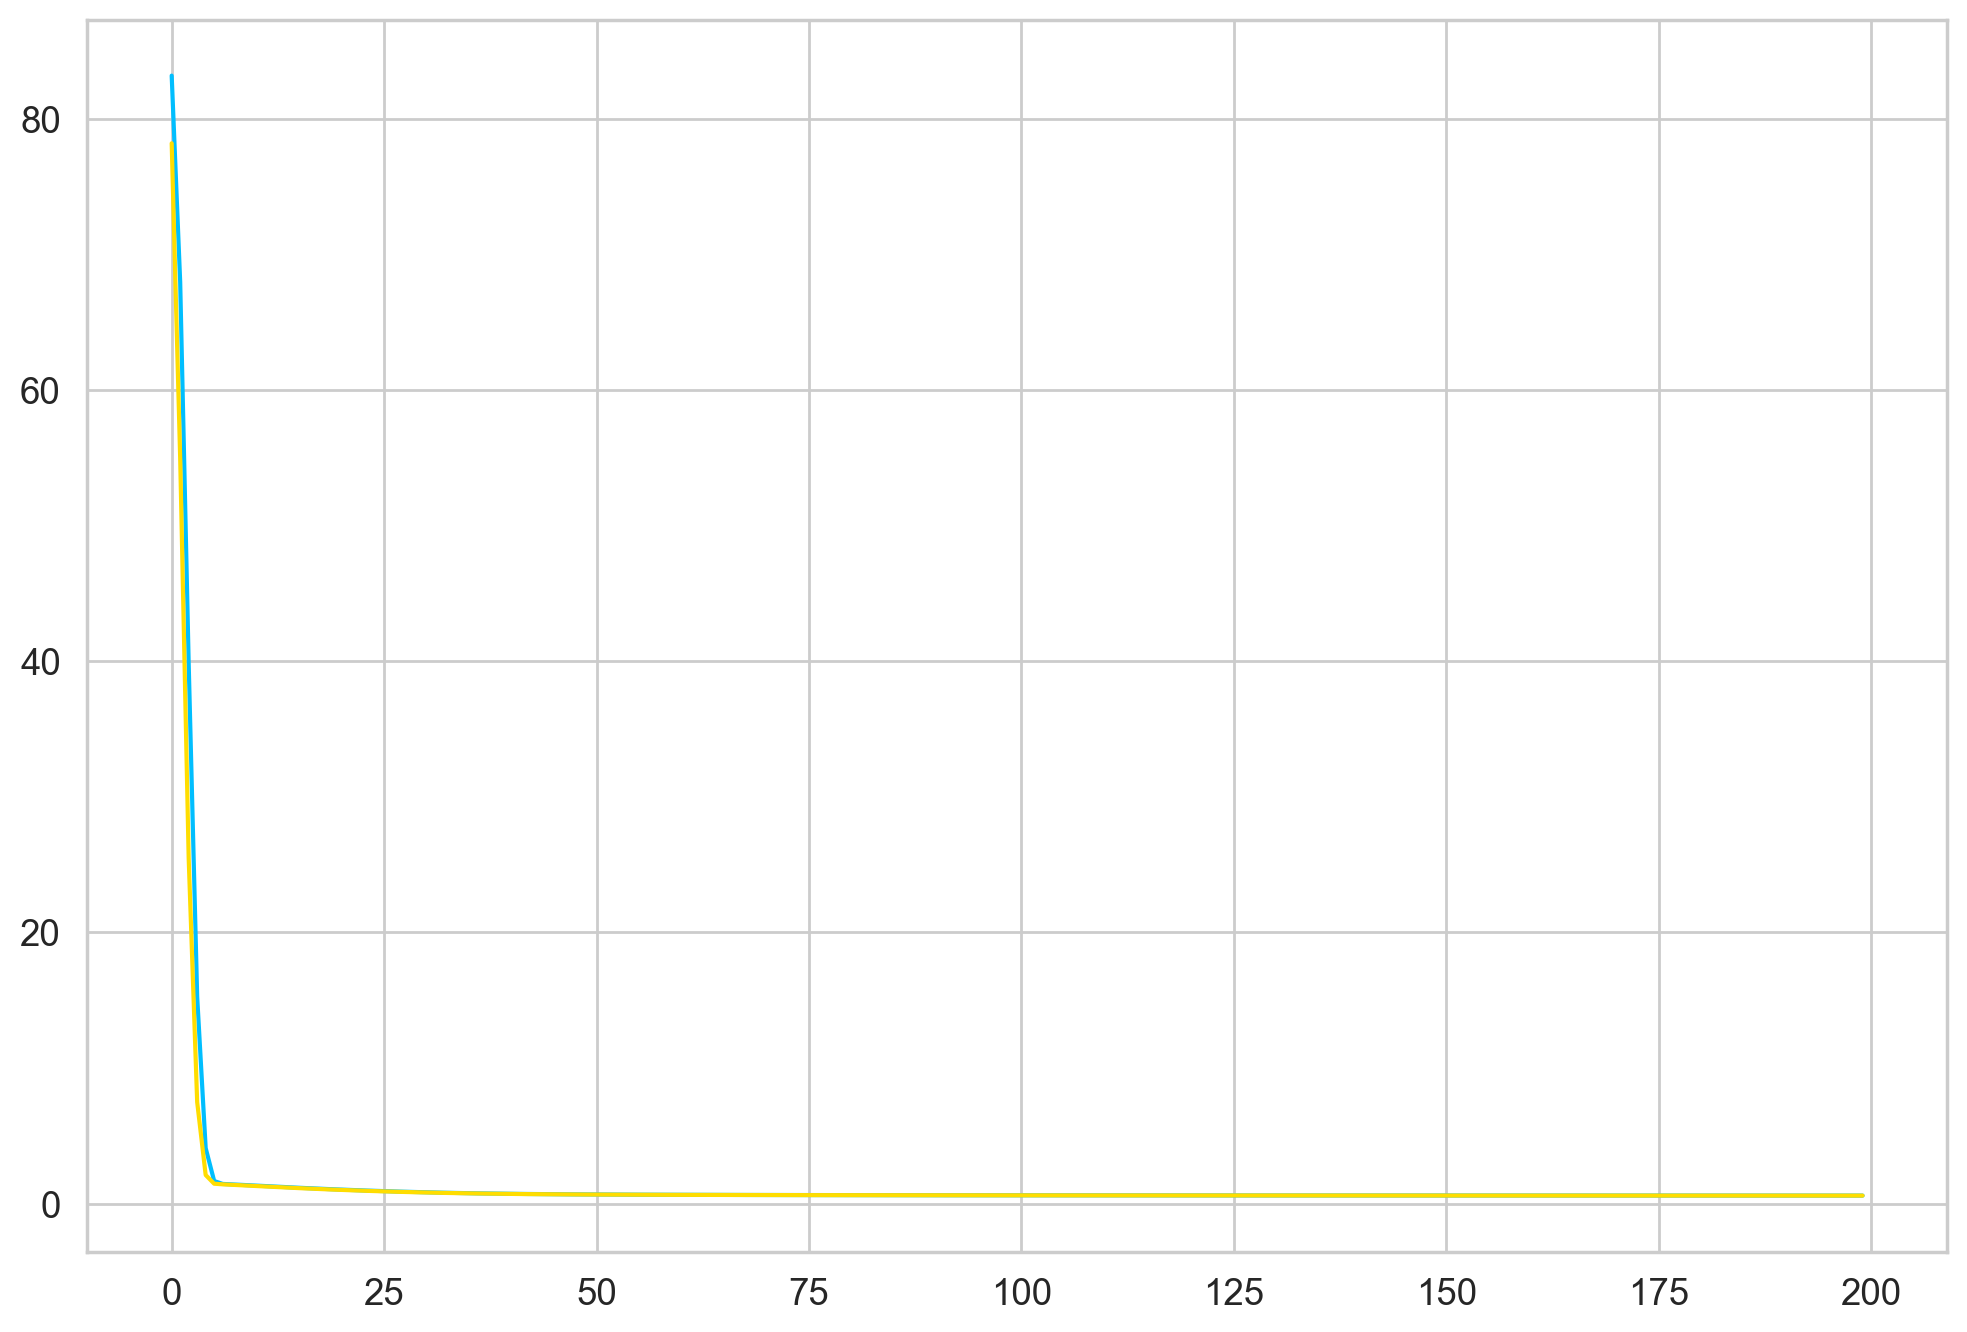

In [21]:
plt.plot(train_losses)
plt.plot(valid_losses)

In [22]:
predictions = []
test_losses = []
running_loss = 0.
model.eval()
with torch.no_grad():
    for idx, (inputs, labels) in enumerate(test_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        preds = model.forward(inputs)
        predictions.append(preds.item())
        loss = criterion(preds,labels)
        running_loss += loss
        
    test_loss = running_loss/len(valid_loader)
    test_losses.append(test_loss.detach().numpy())

In [23]:
predictions

[11.585959434509277,
 11.881765365600586,
 12.305342674255371,
 11.905823707580566,
 11.473301887512207,
 11.043719291687012,
 10.928525924682617,
 11.336385726928711,
 10.51428508758545,
 11.163800239562988,
 11.275580406188965,
 10.6096830368042,
 10.389925003051758,
 10.03285026550293,
 10.08588981628418,
 9.949873924255371,
 9.884818077087402,
 10.144461631774902,
 9.736942291259766,
 9.118561744689941,
 8.5762300491333,
 8.608138084411621,
 8.921107292175293,
 8.86410140991211,
 8.849295616149902,
 9.264031410217285,
 8.749007225036621,
 8.975459098815918,
 8.971701622009277,
 8.635008811950684,
 8.559331893920898,
 9.601033210754395,
 9.456482887268066,
 9.094813346862793,
 10.595677375793457,
 10.872243881225586,
 10.659927368164062,
 9.91256046295166,
 10.358540534973145,
 10.8062744140625,
 10.751383781433105,
 10.2285795211792,
 10.001289367675781,
 10.481807708740234,
 10.410548210144043,
 10.335858345031738,
 10.628340721130371,
 11.252935409545898,
 11.55270004272461,
 11.

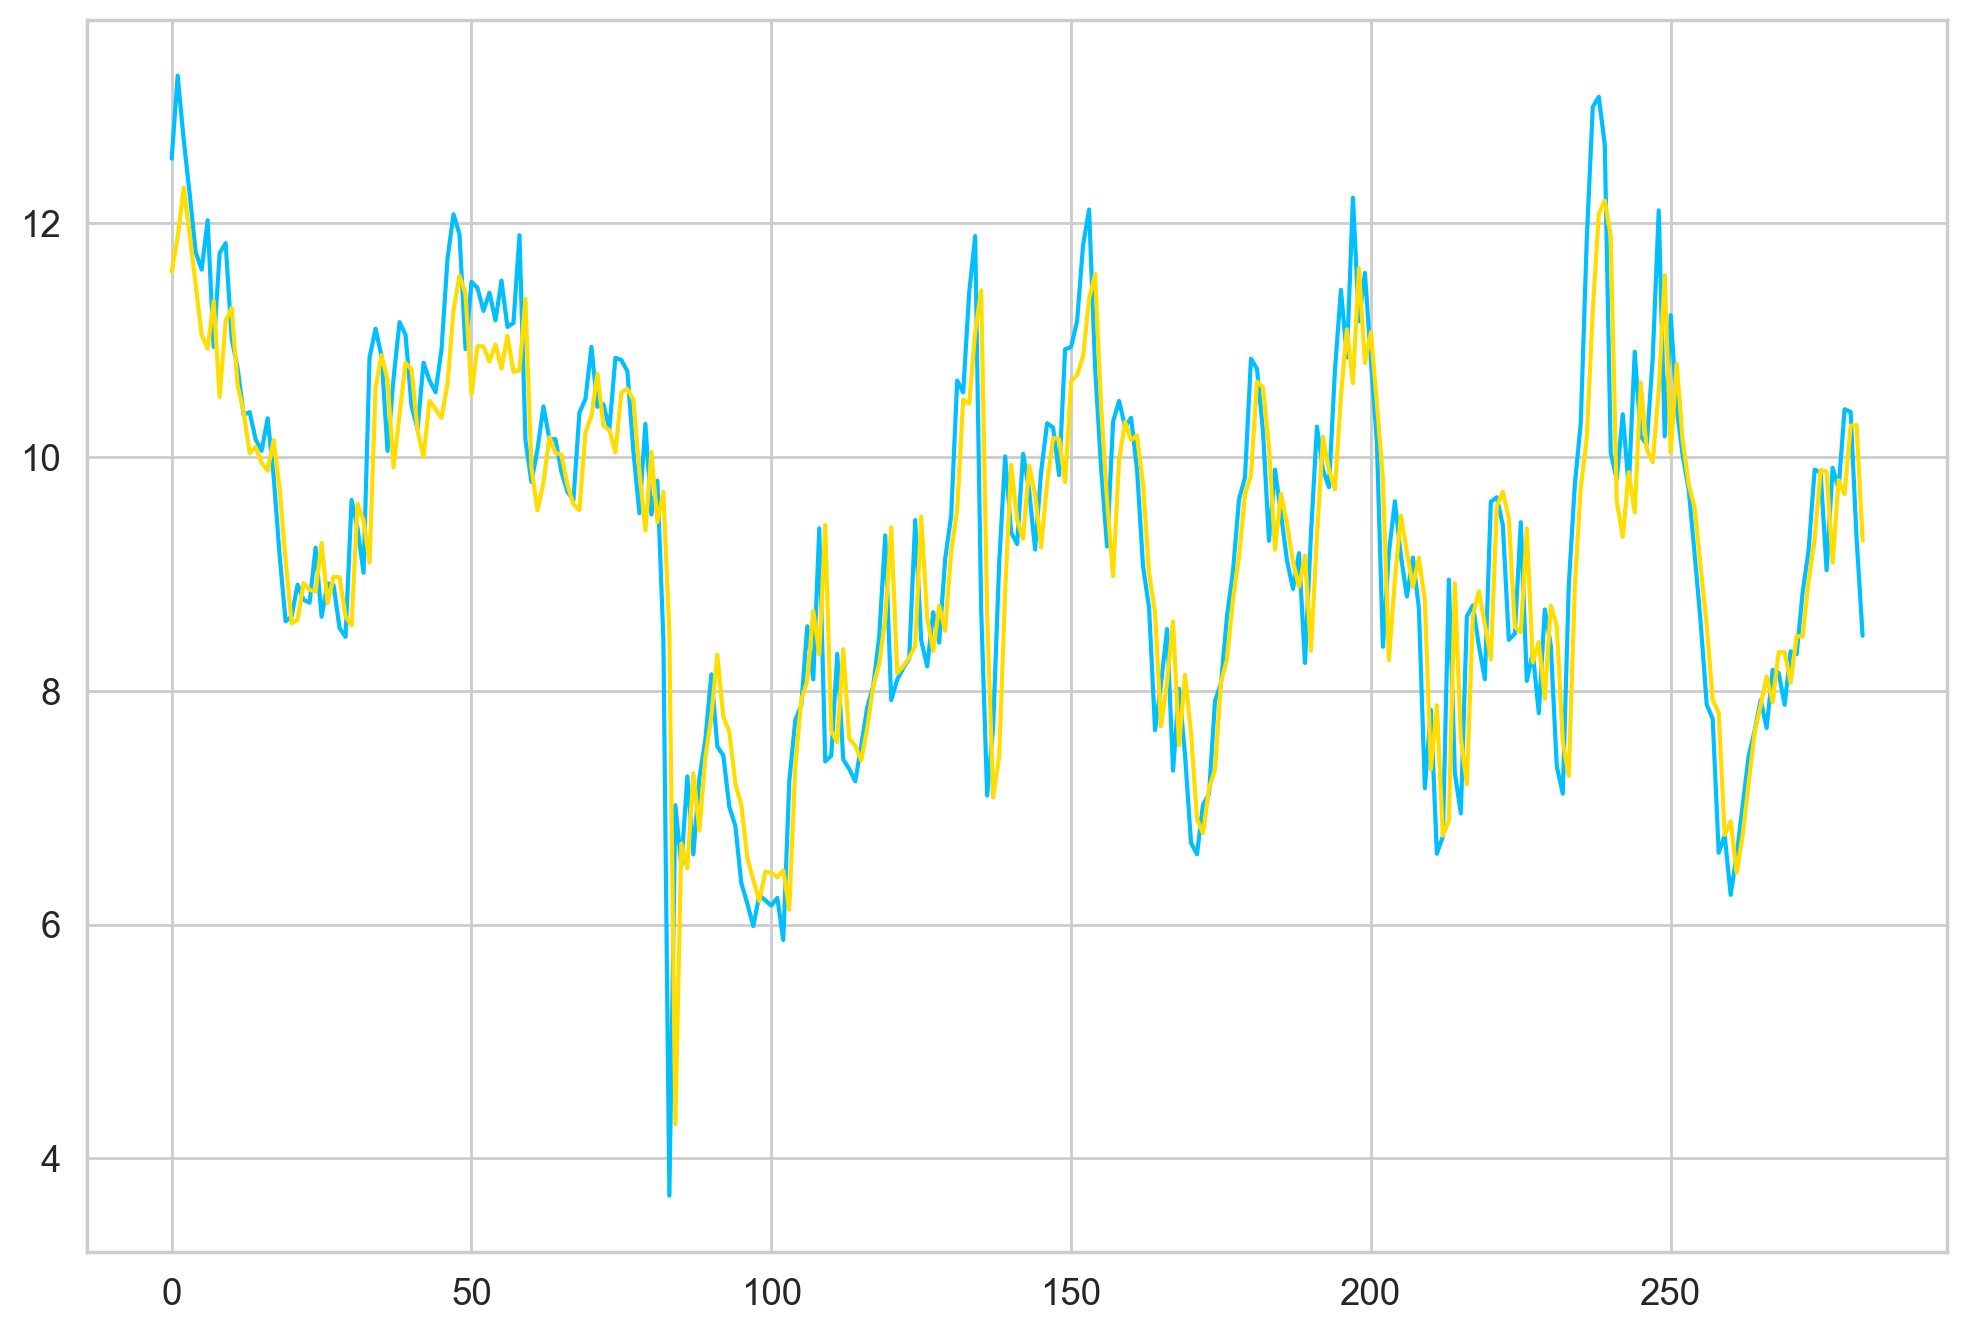

In [24]:
plt.plot(ytest)
plt.plot(predictions)

In [25]:
mse(predictions, ytest)

0.6346399741753832

In [26]:
import pickle

In [27]:
file = open('lstm_1', 'ab')
pickle.dump(predictions, file)
file.close()

#### May Dataset

In [29]:
df = pd.read_csv('inputs/DS2_1448.csv')

In [30]:
window_size = 5
train_len = int(.6*df.shape[0])

In [31]:
train_data, val_data, test_data = split_data(df.wind_speed.values, train_len)
train_data = np.float32(train_data)
val_data = np.float32(val_data)
test_data = np.float32(test_data)

In [32]:
train_data.shape

(892,)

In [33]:
xtrain, ytrain = create_features(train_data, window_size)
xval, yval = create_features(val_data, window_size)
xtest, ytest = create_features(test_data, window_size)

In [34]:
train = WindDataset(xtrain.reshape(xtrain.shape[0], 1, xtrain.shape[1]), ytrain)
valid = WindDataset(xval.reshape(xval.shape[0], 1, xval.shape[1]), yval)
test = WindDataset(xtest.reshape(xtest.shape[0], 1, xtest.shape[1]), ytest)
train_loader = torch.utils.data.DataLoader(train, batch_size=1, shuffle=False)
valid_loader = torch.utils.data.DataLoader(train, batch_size=1, shuffle=False)
test_loader = torch.utils.data.DataLoader(test, batch_size=1, shuffle=False)

In [35]:
input_size = 5 #number of features
hidden_size = 200 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 
seq_length = 1

In [36]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = LSTMForecast(input_size, hidden_size, num_layers, num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = nn.MSELoss()

In [37]:
for p in model.parameters():
    print(p.shape)

torch.Size([800, 5])
torch.Size([800, 200])
torch.Size([800])
torch.Size([800])
torch.Size([100, 200])
torch.Size([100])
torch.Size([1, 100])
torch.Size([1])


In [38]:
NUM_EPOCHS = 200

In [39]:
train_losses = []
valid_losses = []
def Train():
    
    running_loss = .0
    
    model.train()
    
    for idx, (inputs,labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        preds = model(inputs)
        loss = criterion(preds,labels)
        loss.backward()
        optimizer.step()
        running_loss += loss
        
    train_loss = running_loss/len(train_loader)
    train_losses.append(train_loss.detach().numpy())
    
    print(f'train_loss {train_loss}')
    
def Valid():
    running_loss = .0
    
    model.eval()
    
    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(valid_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            preds = model(inputs)
            loss = criterion(preds,labels)
            running_loss += loss
            
        valid_loss = running_loss/len(valid_loader)
        valid_losses.append(valid_loss.detach().numpy())
        print(f'valid_loss {valid_loss}')

In [40]:
for epoch in range(NUM_EPOCHS):
    print('epochs {}/{}'.format(epoch+1, NUM_EPOCHS))
    Train()
    Valid()
    gc.collect()

epochs 1/200
train_loss 36.81461715698242
valid_loss 33.92035675048828
epochs 2/200
train_loss 29.293306350708008
valid_loss 22.990175247192383
epochs 3/200
train_loss 16.14337158203125
valid_loss 9.45401668548584
epochs 4/200
train_loss 5.638810157775879
valid_loss 2.9499881267547607
epochs 5/200
train_loss 2.243617057800293
valid_loss 1.8467984199523926
epochs 6/200
train_loss 1.7941956520080566
valid_loss 1.7436598539352417
epochs 7/200
train_loss 1.7269165515899658
valid_loss 1.7029081583023071
epochs 8/200
train_loss 1.6874250173568726
valid_loss 1.6669191122055054
epochs 9/200
train_loss 1.6519134044647217
valid_loss 1.6319893598556519
epochs 10/200
train_loss 1.616483211517334
valid_loss 1.5971945524215698
epochs 11/200
train_loss 1.5828468799591064
valid_loss 1.5654796361923218
epochs 12/200
train_loss 1.5519587993621826
valid_loss 1.535686731338501
epochs 13/200
train_loss 1.5234440565109253
valid_loss 1.5086948871612549
epochs 14/200
train_loss 1.496948480606079
valid_loss 1.

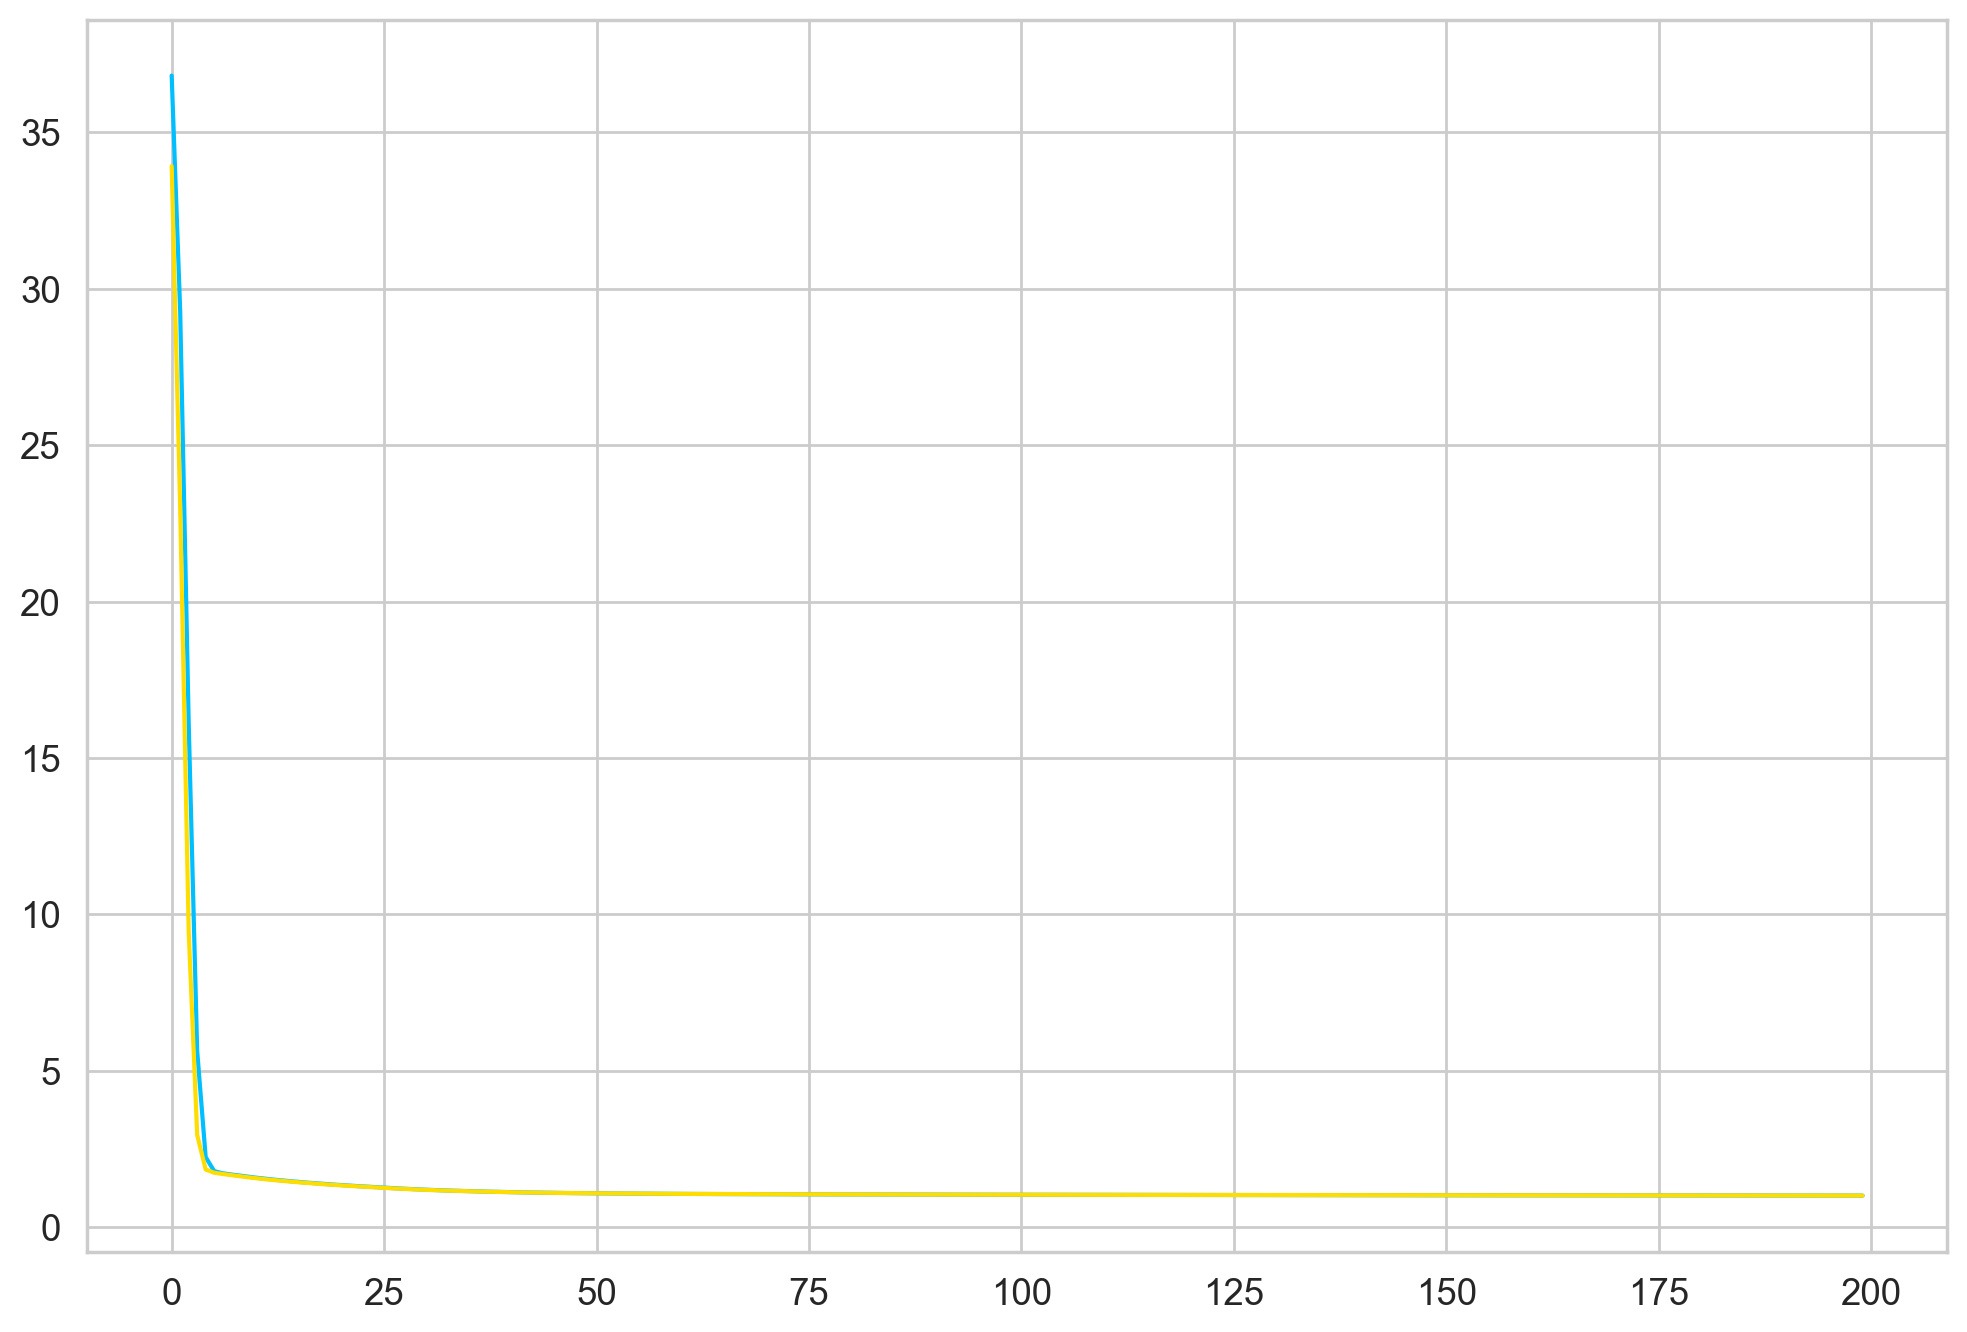

In [46]:
plt.plot(train_losses)
plt.plot(valid_losses)

In [47]:
predictions = []
test_losses = []
running_loss = 0.
model.eval()
with torch.no_grad():
    for idx, (inputs, labels) in enumerate(test_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        preds = model.forward(inputs)
        predictions.append(preds.item())
        loss = criterion(preds,labels)
        running_loss += loss
        
    test_loss = running_loss/len(valid_loader)
    test_losses.append(test_loss.detach().numpy())

In [48]:
predictions

[7.627973556518555,
 8.289942741394043,
 6.445021152496338,
 5.84956693649292,
 6.829083442687988,
 6.147198677062988,
 6.377286911010742,
 6.120459079742432,
 6.245041847229004,
 4.30910587310791,
 3.3268096446990967,
 3.356435775756836,
 3.321070909500122,
 3.5108847618103027,
 3.2337872982025146,
 2.700307846069336,
 3.2842538356781006,
 3.0395612716674805,
 3.129237651824951,
 3.9511187076568604,
 3.1975131034851074,
 2.9566640853881836,
 4.269721984863281,
 6.175029754638672,
 5.383389472961426,
 6.664670944213867,
 7.513559341430664,
 6.669735908508301,
 6.523623943328857,
 7.120155334472656,
 7.274305820465088,
 7.733242034912109,
 8.876166343688965,
 8.5208101272583,
 8.87926197052002,
 8.355886459350586,
 7.746941566467285,
 7.762670993804932,
 7.363104343414307,
 5.800328731536865,
 7.411292552947998,
 7.506430625915527,
 6.892888069152832,
 7.056561470031738,
 7.220820426940918,
 5.70644474029541,
 5.217628479003906,
 4.661209583282471,
 4.566359519958496,
 3.951484441757202

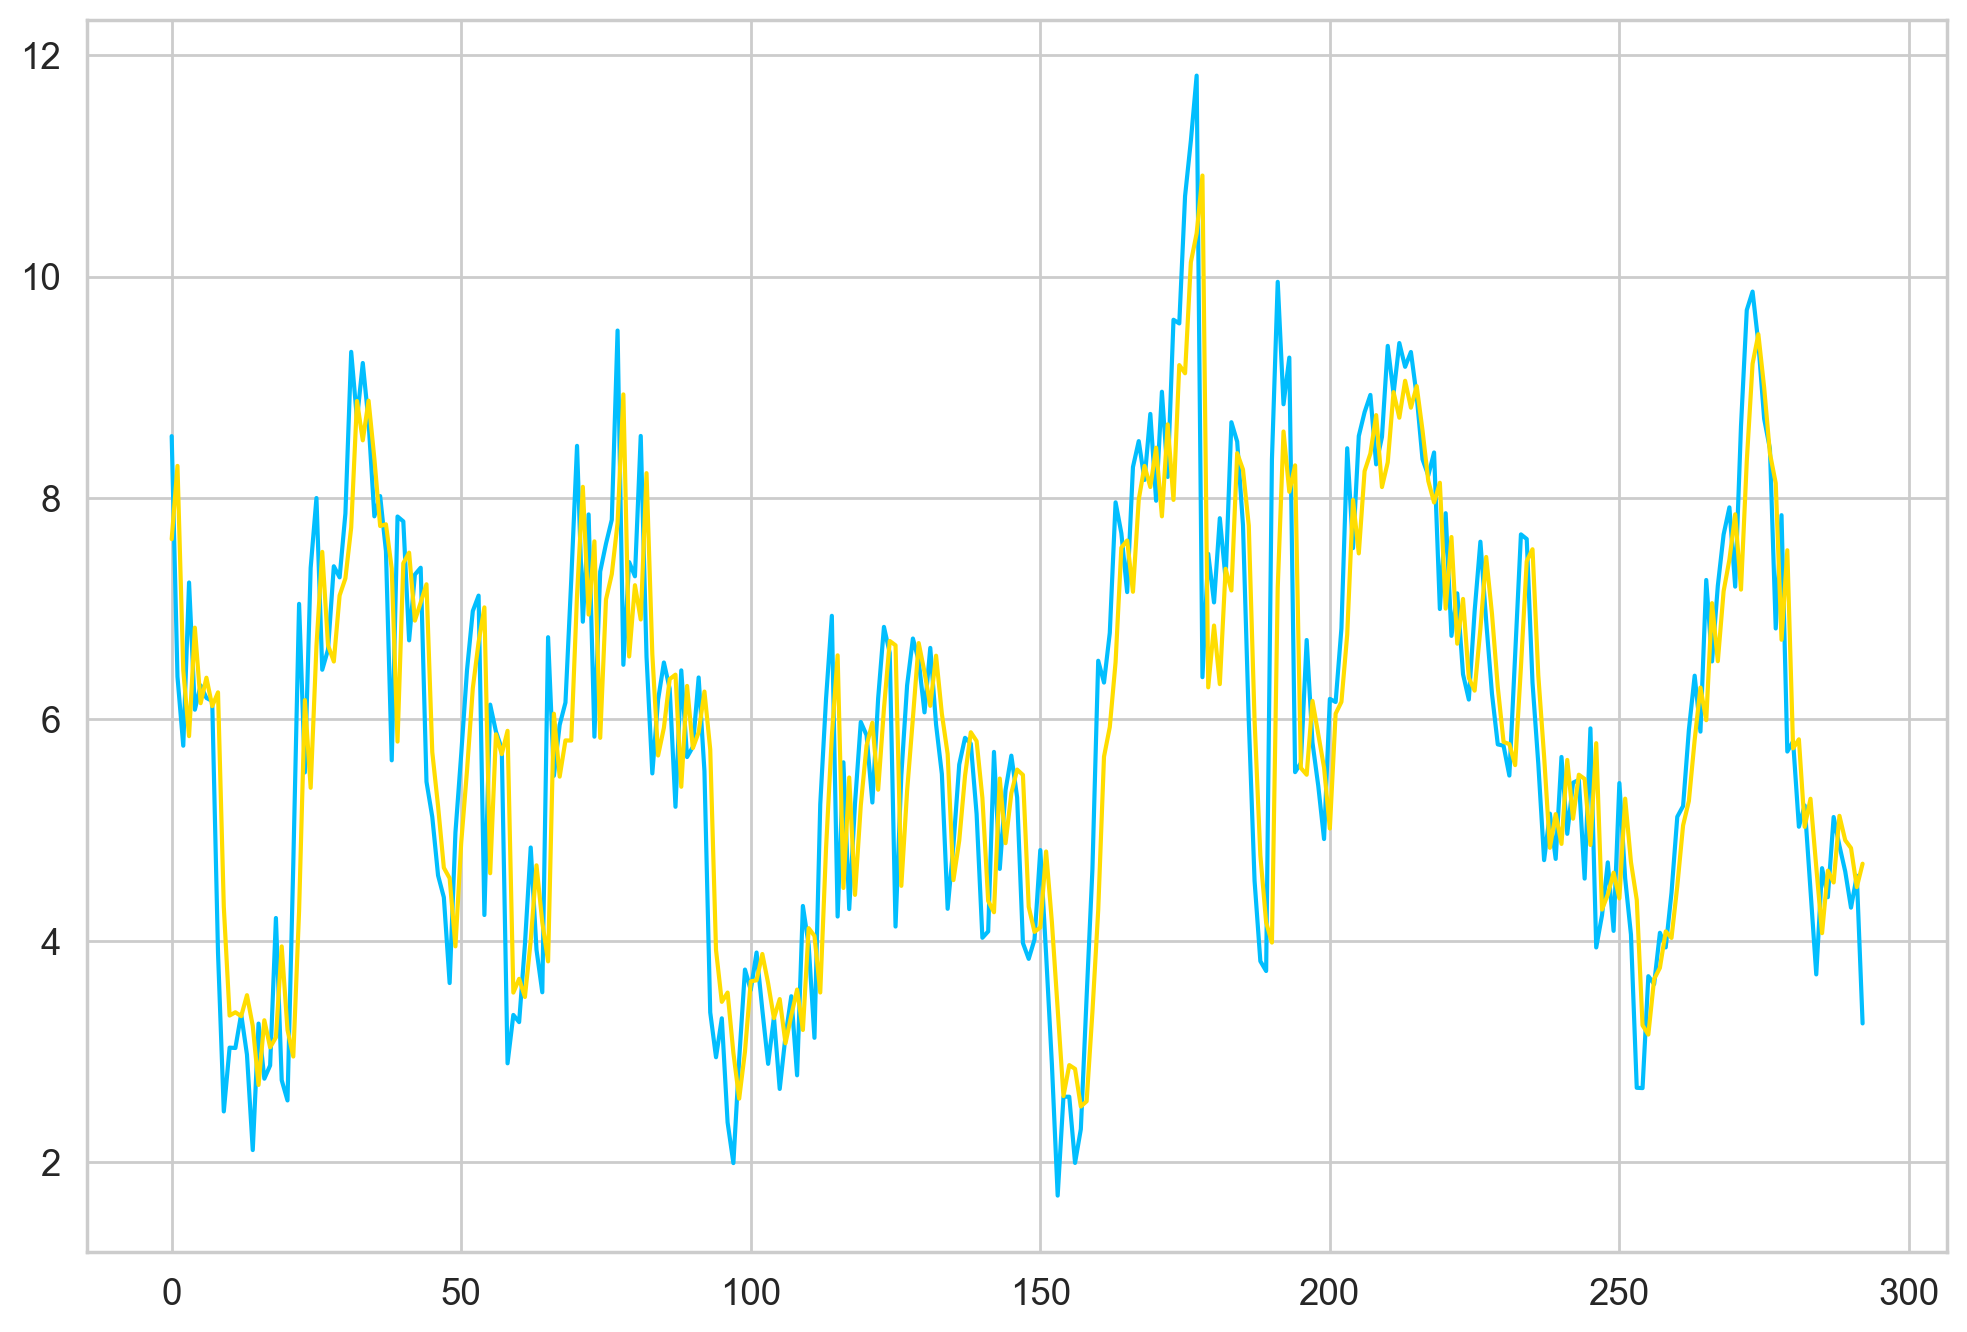

In [49]:
plt.plot(ytest)
plt.plot(predictions)

In [50]:
mse(predictions, ytest)

1.1293691344954175

In [51]:
file = open('lstm_2', 'ab')
pickle.dump(predictions, file)
file.close()